In [62]:
## DESCRIPTION DU PROGRAMME :
# Ce programme applique la méthode K-means à un ensemble de données GPS localisées 
# dans un périmètre choisi et affiche les zones obtenues.

# Dans le cadre du projet, il affiche l'ensemble des données récoltées sur le campus de l'Ecole
# Centrale de Lyon sur une carte du campus afin de déterminer des zones de fréquentation du 
# campus à partir des données.

## PARAMETRES POUVANT ETRE CHANGES : 
# La liste L des points considérés
# Le périmètre qui délimite la zone où l'on considère les points
# datafile3 qui correspond à l'image de fond ainsi que les coordonnéees (extend)associées 
#   à la carte
# nombre_de_zones (jusqu'à 8 pour l'affichage avec des couleurs)
# les couleurs des zones dans couleurs_zones
# la graine de la fonction random.seed
# le nombre d'itérations maximales de la méthode nbre_it

In [63]:
## Quelques imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
from operator import truediv
import time

In [64]:
## On calcule le temps d'exécution
t = time.time()

In [65]:
##Créer une liste des toutes les points [latitude, longitude] de la collecte situés aux 
#alentours du campus
L=["C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_BAI_Yue.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Belhouari_Ahmed.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Chalicarne_Raphael.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Colas_Jules.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Fregosi_Guillaume.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Hanser_Corentin.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Kaprelian_Theo.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Lyon_Fabien.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Perrine_Pauline.json","C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/histo_Qifei_Li.json"]


In [66]:
## Définir un périmètre rectangulaire autour du campus de l'ECL (à l'aide d'Open Street Maps)
lat_nord = 45.78603
lat_sud = 45.78041
long_ouest = 4.76471
long_est = 4.77209

perimetre = [long_ouest, long_est, lat_sud, lat_nord] 
#correspond aux bornes de la carte-petite-centrale : pris comme perimetre du campus

In [67]:
## Définir la carte de fond et son extend, le nombre de zones et leurs couleurs, 
#la graine du random
datafile3 = 'C:/Users/Maude/Documents/ECL/PE/DonneesGPS/K-means/carte_centrale_petite.png'
img3 = plt.imread(datafile3)

extend3 = [4.76471,4.77209,45.78041,45.78603]

nombre_de_zones = 5 #choix du nombre de zones à calculer

couleurs_zones = ['r', 'b', 'y', 'g', 'm', 'c', 'k', 'w'] 
#couleurs disponibles pour les zones (8 maximum)

# utilisation de la fonction random.seed pour pouvoir retrouver certains des résultats
rnd.seed(8)

# choix d'un nombre d'itérations maximal pour limiter le temps d'execution
nbre_it = 10

In [68]:
## Sélectionner les points appartenant au campus
Points = []
long, lat = [], []
# Il faut aussi séléctionner une période de temps correspondant à la collecte
for e in L:
    f=open(e)
    df = pd.read_json(f)
    donnee=df.get("locations")
    for i in range(len(donnee)):
        lo=donnee[i]["longitudeE7"]/1e7
        la=donnee[i]["latitudeE7"]/1e7
        if (lo >= perimetre[0] and lo <= perimetre[1] and la >= perimetre[2] and la <= perimetre[3]) : #points dans le perimetre
            Points.append([lo,la])
            long.append(lo)
            lat.append(la)
f.close()

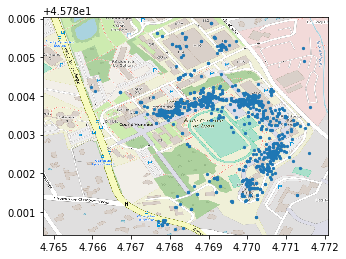

In [69]:
## Affichage des points sur une carte du campus
fig1 = plt.figure(1)

fig1
plt.scatter(long,lat, s=5, zorder=1)
plt.imshow(img3,zorder=0,extent = extend3)

plt.show()

In [70]:
## Délimiter un périmètre où choisir les conditions initiales des centres des zones
perimetre_centres= [min(long), max(long), min(lat), max(lat)]

In [71]:
## Choisir les conditions initiales de la méthode : le nombre de zones et le centre de ces zones

# Autres types de conditions intiales : nombre_de_zones points distincts choisis au hasard dans les donnees (censé améliorer la convergence)

centres_long = [] 
centres_lat = []
Points_donnees=Points.copy()
for i in range(nombre_de_zones) :
    r = rnd.randint(0,len(Points_donnees))
    longitude = long[r]
    latitude = lat[r]
    centres_long.append(longitude)
    centres_lat.append(latitude)
    del (Points_donnees[r])

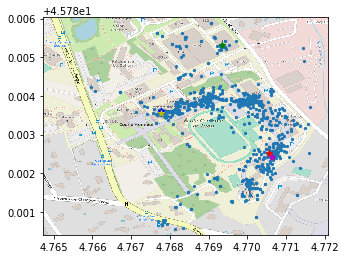

In [72]:
## Affichage des centres sur la carte du campus avec un code couleur

c_long, c_lat = [], []
for i in range(nombre_de_zones) :
    c_long.append([centres_long[i]])
    c_lat.append([centres_lat[i]])

plt.figure(2)

plt.imshow(img3,zorder=0,extent = extend3)

plt.scatter(long,lat, s=5, zorder=1)

for i in range(nombre_de_zones) :
    plt.scatter(centres_long[i], centres_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2)
    
plt.axis(extend3)
plt.show()

In [73]:
## Calcul des zones initiales

def zones_initiales(Points, nombre_de_zones, centres_long, centres_lat):
    Zones = [[] for i in range(nombre_de_zones)] #contiendra la liste des points-vecteurs appartenant à une zone d'indice i

    for i in range(len(Points)): 
        long_p = Points[i][0]
        lat_p = Points[i][1]
        distances_aux_centres= []
        for j in range(nombre_de_zones):
            distance = (Points[i][0]-centres_long[j])**2+(Points[i][1]-centres_lat[j])**2
            distances_aux_centres.append(distance)
        Numero_zone = distances_aux_centres.index(min(distances_aux_centres))
        Zones[Numero_zone].append(Points[i])
        plt.scatter(long_p, lat_p, s=5, c=couleurs_zones[Numero_zone] , zorder=1)
    return Zones

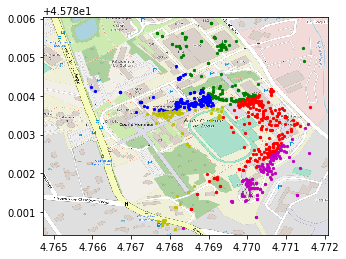

In [74]:
## Affichage points par appartenance aux zones initiales

plt.figure(3)

zones_init = zones_initiales(Points, nombre_de_zones, centres_long, centres_lat)

plt.imshow(img3,zorder=0,extent = extend3)

for i in range(nombre_de_zones) :
    plt.scatter(centres_long[i], centres_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2)


plt.axis(extend3)
plt.show()

In [75]:
## Calcul des 'zones denses': disques tels que si un point appartient au disque alors il est 
#forcément associé au centre du disque

# Méthode adaptée à notre configuration : une forte densité de points en certaines zones

def Rayons(centres_long, centres_lat): 
# renvoie la liste des rayons des disques pour lesquel les points appartenant à un disque 
#sont forcément plus proches du centre associé que des autres centres
    rayons=[]
    for i in range(nombre_de_zones):
        distances=[]
        milieu_x, milieu_y = (centres_long[0]+centres_long[i])/2,(centres_lat[0]+centres_lat[i])/2
        distance_milieu =(centres_long[i]-milieu_x)**2+(centres_lat[i]-milieu_y)**2
        min_distances = distance_milieu
        for j in range(nombre_de_zones):
            if j!=i :
                milieu_x, milieu_y = (centres_long[j]+centres_long[i])/2,(centres_lat[j]+centres_lat[i])/2
                distance_milieu = (centres_long[i]-milieu_x)**2+(centres_lat[i]-milieu_y)**2
                distances.append(distance_milieu)
                if distance_milieu < min_distances :
                    min_distances = distance_milieu
        rayon = min_distances
        rayons.append(rayon)
    return rayons

In [76]:
## Calcul des zones pour une itération

def zones(former_zones, nombre_de_zones, centres_long, centres_lat, rayons): # pour n=1, former_zones = zones_initiales
    Zones = [[] for i in range(nombre_de_zones)]

    for i in range(nombre_de_zones) :
        for j in range(len(former_zones[i])):
            distance_centre = (centres_long[i]-former_zones[i][j][0])**2+(centres_lat[i]-former_zones[i][j][1])**2
            if distance_centre <= rayons[i] :
                Zones[i].append(former_zones[i][j])
                plt.scatter(former_zones[i][j][0],former_zones[i][j][1], s=5, c=couleurs_zones[i] , zorder=1)
            else :
                distances_aux_centres = []
                for p in range(nombre_de_zones):
                    distance = (former_zones[i][j][0]-centres_long[p])**2+(former_zones[i][j][1]-centres_lat[p])**2
                    distances_aux_centres.append(distance)
                Numero_zone = distances_aux_centres.index(min(distances_aux_centres))
                Zones[Numero_zone].append(former_zones[i][j])
                plt.scatter(former_zones[i][j][0],former_zones[i][j][1], s=5, c=couleurs_zones[Numero_zone] , zorder=1)
    return Zones

In [77]:
## Calcul des nouveaux centres des zones pour une étape d'itération :

def new_centres(Zones, nombre_de_zones, centres_long, centres_lat) :
    c_long, c_lat = centres_long, centres_lat
    for j in range(nombre_de_zones):
        n = len(Zones[j])
        if n!=0 :
            sum_long = 0
            sum_lat = 0
            for p in range(n):
                sum_long = sum_long + Zones[j][p][0]
                sum_lat = sum_lat + Zones[j][p][1]
            c_long[j] = truediv(sum_long,n)
            c_lat[j] = truediv(sum_lat,n)
    return c_long, c_lat

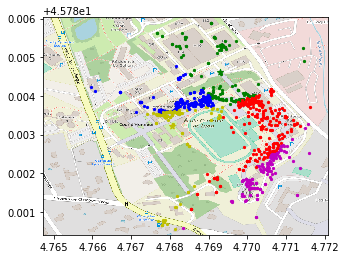

In [78]:
## Représentation des nouveaux centres calculés

plt.figure(4)

rayons = Rayons(centres_long, centres_lat)

Zones = zones_initiales(Points, nombre_de_zones, centres_long, centres_lat)

nvx_centres_long, nvx_centres_lat = new_centres(Zones, nombre_de_zones, centres_long, centres_lat)

nvx_c_long, nvx_c_lat = [], []
for i in range(nombre_de_zones):
    nvx_c_long.append([nvx_centres_long[i]])
    nvx_c_lat.append([nvx_centres_lat[i]])

plt.imshow(img3,zorder=0,extent = extend3)

for i in range(nombre_de_zones) :
    plt.scatter(nvx_c_long[i], nvx_c_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2)

plt.axis(extend3)
plt.show()

In [79]:
## Définir un critère de fin d'itération

# Quand les centres des zones  sont fixes -> boucle while ou à défaut quand le nombre 
# d'itérations maximale est atteint

# On peut envisager un autre critère de convergence moins exigent comme un faible variation de 
# de la position des centres.

In [80]:
## Programme d'itération du calcul des zones et des centres associés

def K_means(zones_initiales, nombre_de_zones, centres_long, centres_lat):
    barycentres_long, barycentres_lat = new_centres(zones_initiales, nombre_de_zones, centres_long, centres_lat)
    former_centres_long,  former_centres_lat = [], []
    former_zones = zones_initiales
    count = 0
    while (barycentres_long != former_centres_long) or (barycentres_lat != former_centres_lat) or (count != nbre_it) :
        rayons = Rayons(barycentres_long, barycentres_lat)
        Zones = zones(former_zones, nombre_de_zones, barycentres_long, barycentres_lat, rayons)
        former_zones = Zones
        c_long, c_lat = new_centres(Zones, nombre_de_zones, barycentres_long, barycentres_lat)
        barycentres_long, former_centres_long = c_long, barycentres_long
        barycentres_lat, former_centres_lat = c_lat, barycentres_lat
        count += 1
        print(count) #on connait ainsi le nombre d'itérations en temps réel
    return barycentres_long, barycentres_lat, count

1
2
3
4
5
6
7
8
9
10


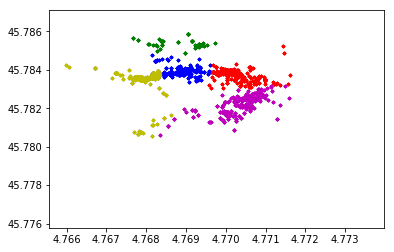

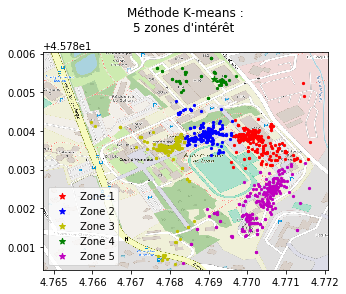

In [81]:
## Tracé de la figure de fin sur une carte du campus : centres et zones

zones_init = zones_initiales(Points, nombre_de_zones, centres_long, centres_lat)

plt.close(fig1) #destiné à effacer la figure parasite qui s'affiche avant la figure 1
# Ne fonctionne apparamment pas.

barycentres_long, barycentres_lat, compteur = K_means(zones_init, nombre_de_zones, centres_long, centres_lat)

plt.figure(5)

Zones = zones_initiales(Points, nombre_de_zones, barycentres_long, barycentres_lat)

baryc_long, baryc_lat = [], []
for i in range(nombre_de_zones):
    baryc_long.append([barycentres_long[i]])
    baryc_lat.append([barycentres_lat[i]])

plt.imshow(img3,zorder=0,extent = extend3)

for i in range(nombre_de_zones) :
    plt.scatter(baryc_long[i], baryc_lat[i], s=40, c=couleurs_zones[i], marker ='*', zorder = 2, label='Zone '+str(i+1))

plt.axis(extend3)

plt.title('Méthode K-means :\n'+ str(nombre_de_zones)+ ' zones d\'intérêt \n')
plt.legend()
plt.show()

In [82]:
## On vérifie le nombre d'itérations avant la convergence et on calcule le temps d'exécution
temps= time.time()-t #temps d'exécution de la méthode
print(compteur)
print(temps)




10
517.330518245697
